<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/lorenz_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

 The subplots function creates a figure and a set of subplots, and returns a tuple containing a reference to the figure and a numpy array of references to the subplots. In this case, the tuple contains a reference to the figure and a reference to the subplot.

The figure object represents the whole figure and the axes object represents the subplot. You can use the axes object to customize the properties of the subplot, such as the axis labels, title, etc. You can also use it to plot data on the subplot. For example:

`ax.plot(x, y, z, 'r')`

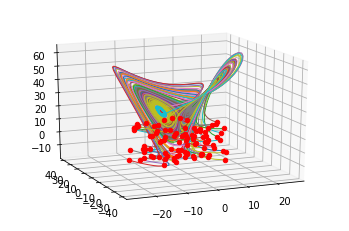

In [ ]:
## Set experiment
dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28

# 100 por len(t)-1 porque se van a guardar 100 trayectorias con longitud de len(t)-1 cada una
# porque len(t)-1 y no solo len(t), porque necesitamos emparejar observaciones en el tiempo
# t con t+1 y esto se logra mediante crear dos vectores, nn_input, nn_output
# el primero no tiene la ultima observacion de cada una de las 100 trajectorias (osea que es de logitud 800)
# y el segundo no tiene la primera observacion de cada una de las 100 trajectorias (osea
# que es de longitud 800) ;)

nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)
# The subplot_kw parameter allows you to specify additional keyword arguments to be passed to the 
# subplot's constructor. In this case, the projection keyword argument is being used to specify that 
# the subplot should be 3D.
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):

    x, y, z = x_y_z
    
    dx = sigma * (y - x)

    dy = x * (rho - z) - y

    dz = x * y - beta * z

    return (dx, dy, dz)

np.random.seed(123)

# Generar 100 condiciones iniciales con valore entre -15 y 15
x0 = -15 + 30 * np.random.random((100, 3))

# (100, 801, 3) odeint regrasa (801, 3) y esto se repite para las 100 condiciones 
# iniciales en x0
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])
# For each of the 100 trajectories
for j in range(100):
    # j=0--------0-----------800-----------------size:800-- cada trayectoria mide 801, 
    # y siempre le quitamos una observacion para dejar 800
    # j=1--------800---------1600----------------size:800--
    # j=2--------1600--------2600----------------size:800--
    # Guardar trayectoria actual, todas las trayectorias quedan sobre el mismo renglon,
    # una depues de la otra, las variables de estado estan una en cada columna
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    # sin transponer es una lista con 801 (801->renglones son los que se 
    # destructuran siempre, 3) valores que tendriamos que guardar 
    # en 801 variables
    # transpuesta es una lista con 3 (3, 801) valores
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

ax.view_init(18, -113)
plt.show()

In [ ]:
j=1
print(x_t[j,:,:].shape)
print(x_t[j,:,:].T.shape)

(801, 3)
(3, 801)


In [ ]:
print(nn_input.shape)
print(x_t.shape)
print(x_t.size) # 100 trayectorias, 801 pasos en cada trayectoria, 3 variables de estado

(80000, 3)
(100, 801, 3)
240300


In [ ]:
100*801*3

240300

In [ ]:
j = 1
print(nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:].shape)
print(x_t[j,:-1,:].shape)

(800, 3)
(800, 3)


In [ ]:
# define regression model
def regression_model():
    # create model
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(3,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Define model 
def model(input_dim, output_dim):

    deep_approx = keras.models.Sequential()

    deep_approx.add(layers.Dense(10, 
                                 input_dim=input_dim, 
                                 activation='sigmoid'))

    deep_approx.add(layers.Dense(10, 
                                 activation='relu'))

    deep_approx.add(layers.Dense(output_dim, 
                                 activation='linear'))

    return deep_approx

In [ ]:
deep_approx = model(3,3)

In [ ]:
# Compile model 
deep_approx.compile(loss='mse', optimizer='adam')

In [ ]:
# Fit model 
History = deep_approx.fit(nn_input, nn_output, epochs=100)

Epoch 1/100
2500/2500 [==============================] - 13s 4ms/step - loss: 43.9147
Epoch 2/100
2500/2500 [==============================] - 6s 2ms/step - loss: 2.4186
Epoch 3/100
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6624
Epoch 4/100
2500/2500 [==============================] - 6s 2ms/step - loss: 0.3193
Epoch 5/100
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1740
Epoch 6/100
2500/2500 [==============================] - 6s 2ms/step - loss: 0.1063
Epoch 7/100
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0722
Epoch 8/100
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0540
Epoch 9/100
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0437
Epoch 10/100
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0368
Epoch 11/100
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0315
Epoch 12/100
2500/2500 [==============================] - 5s 2ms/step - 

In [ ]:
# Predict three new trajectories 
num_traj = 3
nn_flow = np.zeros((num_traj, len(t), 3))

np.random.seed(139)
nn_flow[:, 0, :] = -15 + 30*np.random.random((num_traj, 3))

# Esto el lo que decia el articulo hacerca de no hacer predicciones
# con la ultima observacion 
for jj, tval in enumerate(t[:-1]):
    nn_flow[:,jj+1, :] = deep_approx.predict(nn_flow[:, jj,:])

1/1 [==============================] - 0s 15ms/step


In [ ]:
# para cada una de las tres condiciones iniciales calcular una trayectoria con 801 observaciones
# y tres variables de estado
# esto nos da (3, 801, 3)
x_t = np.array([integrate.odeint(lorenz_deriv, nn_flow[i, 0, :], t) for i in range(num_traj)])

In [ ]:
print(x_t.shape)

(3, 801, 3)


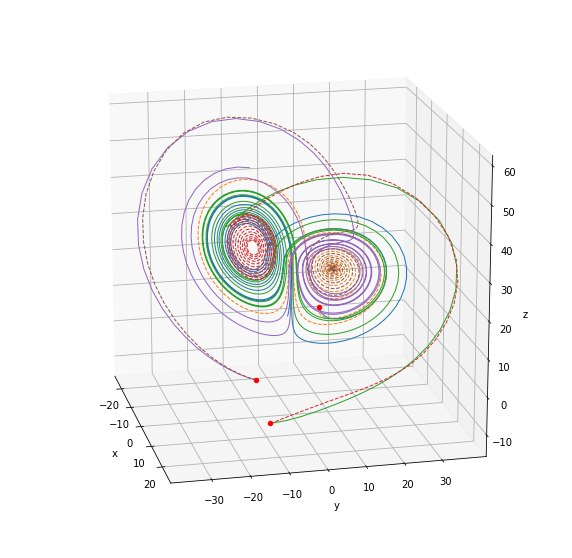

In [ ]:
fig = plt.figure(figsize=(10,10))
# fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
ax = fig.add_subplot(111, projection='3d')
for j in range(num_traj):
    # Transponemos para podes descructurar 3 variables 
    # necitas (3, 801), es decir, las variables de estado en los renglones
    x, y, z = x_t[j, :, :].T
    xd, yd, zd = nn_flow[j, :, :].T

    ax.plot(x, y, z, linewidth=1)
    ax.plot(xd, yd, zd, '--', lw=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.scatter(x[0], y[0], z[0], color='r')

ax.view_init(18, -13)
plt.show()